# Problem Outline

Consider a dataset (`ground_control_points.csv`, measured in eastings and northings) representing a set of ground control points. The coordinates of these points have also been measured using satellite imaging (`coordinates.csv`, as `x` and `y` coordinates).  

A suitable model for transforming the data from the imaged coordinates into the ground coordinates is to be derived, and the best estimates of the corresponding parameters are to be determined.

Candidate models are the **similarity** and **affine** transformations, the equations for which are given below.

## Forming The Matrices

### Transformation Direction

The problem asks us to transform **image → ground**: given image coordinates $(x, y)$, predict ground coordinates $(E, N)$.

This means:
- **Predictors** (design matrix columns): image coordinates $x, y$
- **Response** (observation vector $\mathbf{b}$): ground coordinates $E, N$

### Similarity
The similarity transformation uses 4 parameters $(a, b, \Delta_E, \Delta_N)$:
\begin{align}
E_i &= ax_i - by_i + \Delta_E \\
N_i &= bx_i + ay_i + \Delta_N
\end{align}

where $a = s\cos\theta$ and $b = s\sin\theta$, with $s$ being scale and $\theta$ rotation.

The design matrix $\mathbf{A}_{sim}$ for stacked observations $[E_1, \ldots, E_n, N_1, \ldots, N_n]^T$:

\begin{bmatrix}
x_1 & -y_1 & 1 & 0 \\
\vdots & \vdots & \vdots & \vdots \\
x_n & -y_n & 1 & 0 \\
x_1 & y_1 & 0 & 1 \\
\vdots & \vdots & \vdots & \vdots \\
x_n & y_n & 0 & 1
\end{bmatrix}

### Affine
The affine transformation uses 6 parameters:
\begin{align}
E_i &= a_0 + a_1 x_i + a_2 y_i \\
N_i &= b_0 + b_1 x_i + b_2 y_i
\end{align}

The design matrix $\mathbf{A}_{aff}$:

\begin{bmatrix}
1 & x_1 & y_1 & 0 & 0 & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
1 & x_n & y_n & 0 & 0 & 0 \\
0 & 0 & 0 & 1 & x_1 & y_1 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
0 & 0 & 0 & 1 & x_n & y_n
\end{bmatrix}

### Observation Vector
The $\mathbf{b}$ vector contains all $E$ coordinates followed by all $N$ coordinates:
$$\mathbf{b} = [E_1, E_2, \ldots, E_n, N_1, N_2, \ldots, N_n]^T$$

## Weighting in WLS

### The Principle

In Weighted Least Squares, each observation is weighted inversely proportional to its variance:
$$w_i = \frac{1}{\sigma_i^2}$$

The WLS estimator minimizes:
$$\sum_i w_i (y_i - \hat{y}_i)^2 = \mathbf{v}^T \mathbf{W} \mathbf{v}$$

where $\mathbf{W}$ is a diagonal matrix of weights.

### What Should $\sigma_i^2$ Represent?

**Conceptually**: $\sigma_i^2$ should be the **measurement uncertainty** of observation $i$: how precisely was that coordinate measured? This might come from:
- Instrument specifications (e.g., GPS receiver precision)
- Repeated measurements at each point
- Known digitization error in image measurements

**What the data uses**: The sample variance of the coordinate values themselves (computed via `std()`). This measures **spatial spread**: how dispersed the points are – not measurement precision.

These are fundamentally different quantities:
- Points spread over 1000m have high spatial variance, but each might be measured to ±1cm
- Points clustered in 1m have low spatial variance, but might have ±10m measurement error

Note that use of these weights is is a pedagogical simplification rather than a statistically rigorous approach.

### Statsmodels Convention

`statsmodels.WLS` expects `weights = 1/σ²` directly (not the variance itself).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
# imaged observations (predictors for image→ground)
coords = pd.read_csv('../data/coordinates.csv', index_col=0)
# ground control points (response for image→ground)
ground_control_points = pd.read_csv('../data/ground_control_points.csv')

print(f"Number of points: {len(coords)}")
print("\nImage coordinates (x, y):")
print(coords.head())
print("\nGround control points (E, N):")
print(ground_control_points.head())

Number of points: 54

Image coordinates (x, y):
       x_coordinates  y_coordinates
index                              
0          -0.149588      -0.149533
1           0.117489       0.014296
2           0.071546       0.098656
3           0.012923      -0.146466
4           0.059942       0.008803

Ground control points (E, N):
             E            N
0  501840.7579  185681.5922
1  502808.3026  186667.6431
2  502509.0600  186961.7100
3  502543.4900  185883.5300
4  502564.6500  186577.9900


## Build Design Matrices

Functions take image coordinate tuples $(x, y)$ and return design matrices for the image→ground transformation.

In [ ]:
def similarity_dict(points):
    """
    Design matrix for similarity transform: image → ground
    Parameters: [a, b, ΔE, ΔN]
    
    E = ax - by + ΔE
    N = bx + ay + ΔN
    """
    n = len(points)
    zeros = np.zeros(n)
    ones = np.ones(n)
    x = np.array([p[0] for p in points])
    y = np.array([p[1] for p in points])
    return {
        'a': np.concatenate([x, y]),      # coefficient of a
        'b': np.concatenate([-y, x]),     # coefficient of b
        'Delta_E': np.concatenate([ones, zeros]),
        'Delta_N': np.concatenate([zeros, ones])
    }

def affine_dict(points):
    """
    Design matrix for affine transform: image → ground
    Parameters: [a0, a1, a2, b0, b1, b2]
    
    E = a0 + a1*x + a2*y
    N = b0 + b1*x + b2*y
    """
    n = len(points)
    zeros = np.zeros(n)
    ones = np.ones(n)
    x = np.array([p[0] for p in points])
    y = np.array([p[1] for p in points])
    return {
        'a0': np.concatenate([ones, zeros]),
        'a1x': np.concatenate([x, zeros]),
        'a2y': np.concatenate([y, zeros]),
        'b0': np.concatenate([zeros, ones]),
        'b1x': np.concatenate([zeros, x]),
        'b2y': np.concatenate([zeros, y])
    }

## Form Design Matrices

In [ ]:
# Create list of (x, y) tuples from image coordinates
image_points = list(zip(coords['x_coordinates'], coords['y_coordinates']))

# Build design matrices
similarity_A = pd.DataFrame(similarity_dict(image_points))
affine_A = pd.DataFrame(affine_dict(image_points))

print("Similarity design matrix shape:", similarity_A.shape)
similarity_A.head()

Similarity design matrix shape: (108, 4)


,a,b,Delta_E,Delta_N
0,-0.149588,0.149533,1.0,0.0
1,0.117489,-0.014296,1.0,0.0
2,0.071546,-0.098656,1.0,0.0
3,0.012923,0.146466,1.0,0.0
4,0.059942,-0.008803,1.0,0.0


In [ ]:
print("Affine design matrix shape:", affine_A.shape)
affine_A.head()

Affine design matrix shape: (108, 7)


,a0,a1x,a2y,b0,b1x,b2y,ground_coords
0,1.0,-0.149588,-0.149533,0.0,0.0,0.0,501840.7579
1,1.0,0.117489,0.014296,0.0,0.0,0.0,502808.3026
2,1.0,0.071546,0.098656,0.0,0.0,0.0,502509.0600
3,1.0,0.012923,-0.146466,0.0,0.0,0.0,502543.4900
4,1.0,0.059942,0.008803,0.0,0.0,0.0,502564.6500


## Form Observation Vector (b)

For image→ground, the observations are the **ground coordinates** $(E, N)$.

In [ ]:
# Observation vector: [E1, ..., En, N1, ..., Nn]
b_vector = pd.DataFrame({
    'ground_coords': pd.concat([
        ground_control_points['E'],
        ground_control_points['N']
    ], ignore_index=True)
})

print(f"Observation vector shape: {b_vector.shape}")
print("First 5 (E coords):")
print(b_vector.head())
print("\nLast 5 (N coords):")
print(b_vector.tail())

Observation vector shape: (108, 1)
First 5 (E coords):
   ground_coords
0    501840.7579
1    502808.3026
2    502509.0600
3    502543.4900
4    502564.6500

Last 5 (N coords):
     ground_coords
103      186334.17
104      186887.68
105      186339.49
106      186129.08
107      186858.74


## Join Design Matrix and Observation Vector

In [ ]:
similarity_A = similarity_A.join(b_vector)
affine_A = affine_A.join(b_vector)

## Create Covariance / Weight Vector

variance = sample variance of coordinate values.

Since we're predicting ground coordinates $(E, N)$, the weights should reflect uncertainty in $E$ and $N$ observations.

In [ ]:
half = len(ground_control_points)

# Variance of E coordinates and N coordinates
var_E = ground_control_points['E'].std() ** 2
var_N = ground_control_points['N'].std() ** 2

# Covariance vector: [σ²_E repeated n times, σ²_N repeated n times]
covariance = pd.Series([var_E] * half + [var_N] * half)

print(f"Variance of E: {var_E:.2f}")
print(f"Variance of N: {var_N:.2f}")
print(f"\nStd dev of E: {np.sqrt(var_E):.2f}")
print(f"Std dev of N: {np.sqrt(var_N):.2f}")

# Weights for WLS: w = 1/σ²
weights = 1 / covariance
print(f"\nWeight for E observations: {weights.iloc[0]:.2e}")
print(f"Weight for N observations: {weights.iloc[half]:.2e}")

Variance of E: 137515.43
Variance of N: 159372.95

Std dev of E: 370.83
Std dev of N: 399.22

Weight for E observations: 7.27e-06
Weight for N observations: 6.27e-06


## Carry Out the Regressions

In [ ]:
# Similarity transform
similarity_results = sm.WLS(
    similarity_A['ground_coords'],
    similarity_A[['a', 'b', 'Delta_E', 'Delta_N']],
    weights=weights
).fit()

similarity_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          ground_coords   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.350e+09
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:28:16   Log-Likelihood:                -397.57
No. Observations:                 108   AIC:                             803.1
Df Residuals:                     104   BIC:                             813.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a           4242.6901     10.804    392.698      0.000    4221.265    4264.115
b           1142.7102     10.825    105.565      0.000    1121.244    1164.176
Delta_E     5.023e+05      1.289    3.9e+05      0.000    5.02e+05    5.02e+05
Delta_N     1.865e+05      1.387   1.34e+05      0.000    1.86e+05    1.86e+05
==============================================================================
Omnibus:                       13.360   Durbin-Watson:                   2.410
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                4.204
Skew:                          -0.014   Prob(JB):                        0.122
Kurtosis:                       2.034   Cond. No.                         8.51
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
# Affine transform
affine_results = sm.WLS(
    affine_A['ground_coords'],
    affine_A[['a0', 'a1x', 'a2y', 'b0', 'b1x', 'b2y']],
    weights=weights
).fit()

affine_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:          ground_coords   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.521e+11
Date:                Mon, 15 Dec 2025   Prob (F-statistic):               0.00
Time:                        20:28:23   Log-Likelihood:                -218.31
No. Observations:                 108   AIC:                             448.6
Df Residuals:                     102   BIC:                             464.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
a0          5.023e+05      0.249   2.02e+06      0.000    5.02e+05    5.02e+05
a1x         4346.9014      2.917   1489.982      0.000    4341.115    4352.688
a2y        -1180.6363      2.994   -394.291      0.000   -1186.576   -1174.697
b0          1.865e+05      0.268   6.96e+05      0.000    1.86e+05    1.86e+05
b1x         1168.0215      3.141    371.895      0.000    1161.792    1174.251
b2y         4120.8906      3.224   1278.381      0.000    4114.497    4127.284
==============================================================================
Omnibus:                      133.907   Durbin-Watson:                   2.072
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2221.323
Skew:                           4.602   Prob(JB):                         0.00
Kurtosis:                      23.222   Cond. No.                         14.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Extract and Display Parameters

In [ ]:
print("SIMILARITY PARAMETERS (image → ground)")
print("="*50)
sim_params = similarity_results.params
sim_se = similarity_results.bse
for name in ['a', 'b', 'Delta_E', 'Delta_N']:
    print(f"{name:>10}: {sim_params[name]:>15.6f} ± {sim_se[name]:.6f}")

# Derived quantities
scale = np.sqrt(sim_params['a']**2 + sim_params['b']**2)
rotation = np.degrees(np.arctan2(sim_params['b'], sim_params['a']))
print(f"\n{'Scale':>10}: {scale:>15.6f}")
print(f"{'Rotation':>10}: {rotation:>15.4f}°")

SIMILARITY PARAMETERS (image → ground)
         a:     4242.690069 ± 10.803957
         b:     1142.710196 ± 10.824668
   Delta_E:   502315.381555 ± 1.289181
   Delta_N:   186473.579664 ± 1.387026

     Scale:     4393.882749
  Rotation:         15.0741°


In [ ]:
print("AFFINE PARAMETERS (image → ground)")
print("="*50)
aff_params = affine_results.params
aff_se = affine_results.bse
for name in ['a0', 'a1x', 'a2y', 'b0', 'b1x', 'b2y']:
    print(f"{name:>10}: {aff_params[name]:>15.6f} ± {aff_se[name]:.6f}")

AFFINE PARAMETERS (image → ground)
        a0:   502314.938403 ± 0.248709
       a1x:     4346.901396 ± 2.917419
       a2y:    -1180.636349 ± 2.994326
        b0:   186472.241635 ± 0.267746
       b1x:     1168.021496 ± 3.140728
       b2y:     4120.890556 ± 3.223522


## Compute Quality Metrics

Compute $\mathbf{v}^T \mathbf{W} \mathbf{v}$ and $\sigma_0$ (sigma-nought).

In [ ]:
def compute_quality(results, n_obs, n_params, weights):
    """Compute vᵀWv and σ₀ for a fitted model."""
    resid = results.resid
    vTWv = np.sum(weights * resid**2)
    dof = n_obs - n_params
    sigma0 = np.sqrt(vTWv / dof)
    return vTWv, dof, sigma0

n_obs = len(b_vector)

vTWv_sim, dof_sim, sigma0_sim = compute_quality(similarity_results, n_obs, 4, weights)
vTWv_aff, dof_aff, sigma0_aff = compute_quality(affine_results, n_obs, 6, weights)

print("QUALITY COMPARISON")
print("="*60)
print(f"{'Metric':<25} {'Similarity':>15} {'Affine':>15}")
print("-"*60)
print(f"{'Parameters':<25} {4:>15} {6:>15}")
print(f"{'Degrees of freedom':<25} {dof_sim:>15} {dof_aff:>15}")
print(f"{'vᵀWv':<25} {vTWv_sim:>15.6f} {vTWv_aff:>15.6f}")
print(f"{'σ₀ (sigma-nought)':<25} {sigma0_sim:>15.6f} {sigma0_aff:>15.6f}")
print(f"{'R²':<25} {similarity_results.rsquared:>15.9f} {affine_results.rsquared:>15.9f}")

QUALITY COMPARISON
Metric                         Similarity          Affine
------------------------------------------------------------
Parameters                              4               6
Degrees of freedom                    104             102
vᵀWv                             0.067302        0.002434
σ₀ (sigma-nought)                0.025439        0.004885
R²                            0.999999996     1.000000000


## Residual Analysis

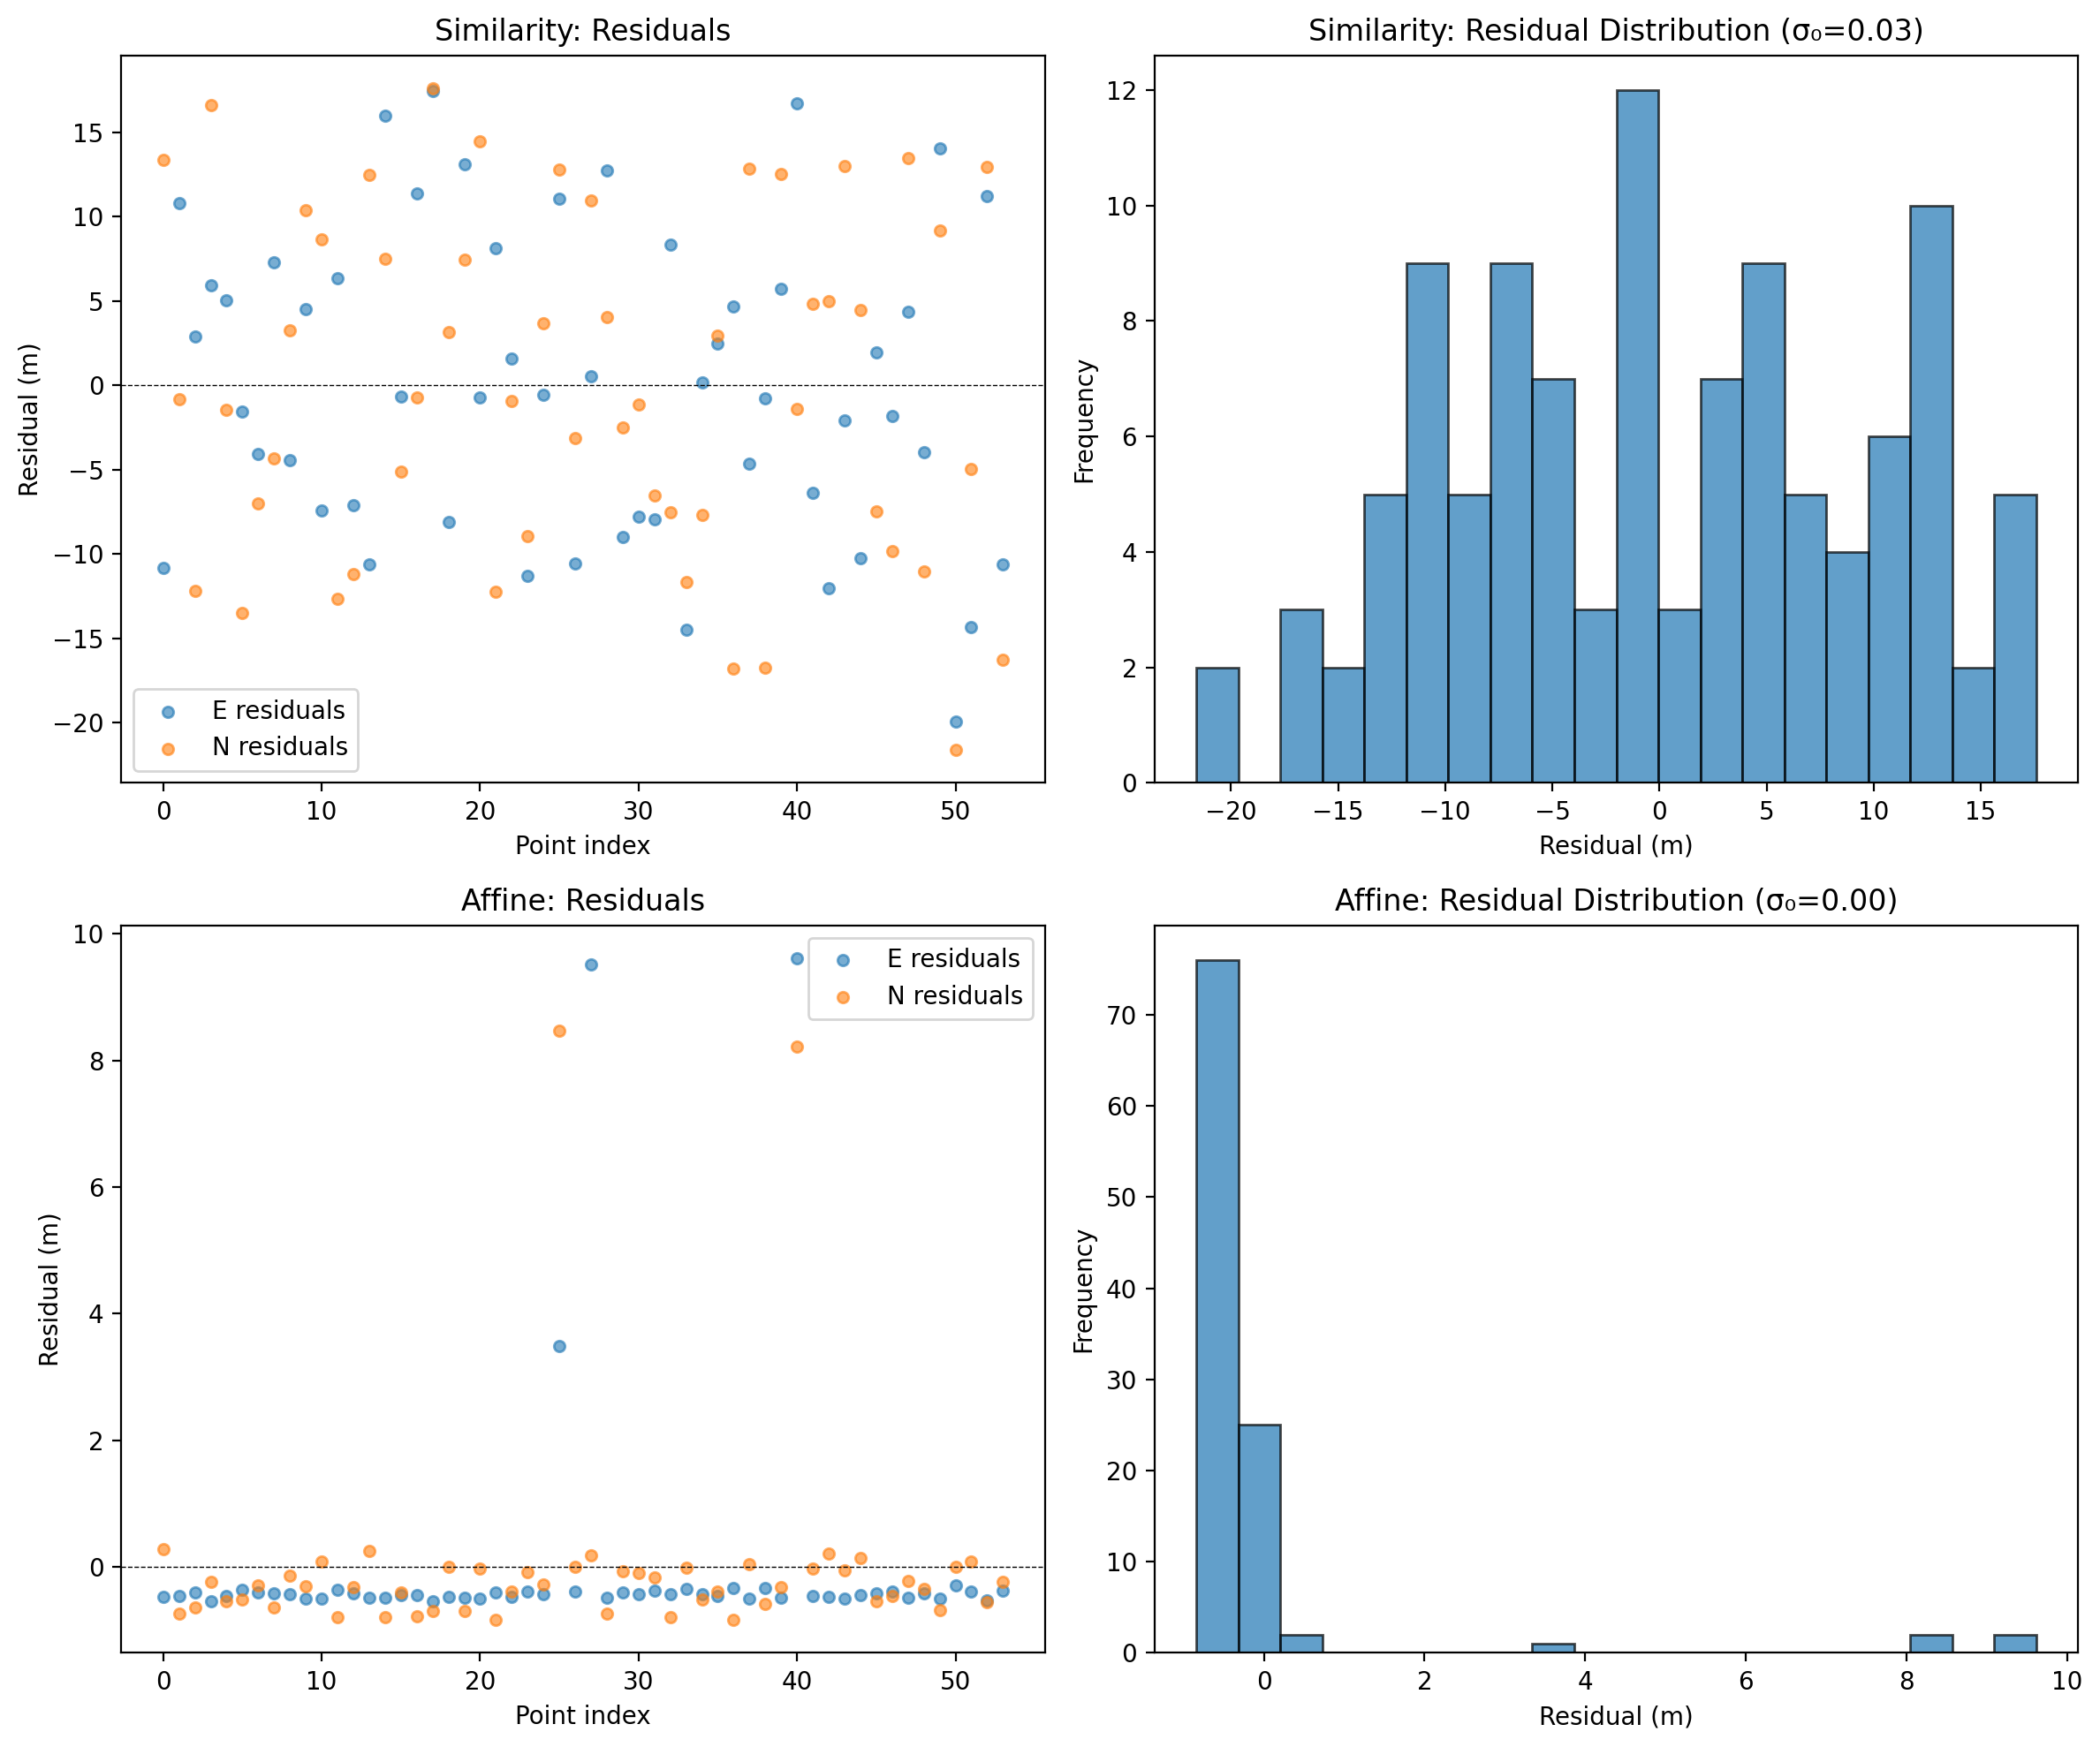

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Similarity residuals
resid_sim = similarity_results.resid
axes[0, 0].scatter(range(half), resid_sim[:half], alpha=0.6, label='E residuals', s=20)
axes[0, 0].scatter(range(half), resid_sim[half:], alpha=0.6, label='N residuals', s=20)
axes[0, 0].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[0, 0].set_xlabel('Point index')
axes[0, 0].set_ylabel('Residual (m)')
axes[0, 0].set_title('Similarity: Residuals')
axes[0, 0].legend()

axes[0, 1].hist(resid_sim, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residual (m)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Similarity: Residual Distribution (σ₀={sigma0_sim:.2f})')

# Affine residuals  
resid_aff = affine_results.resid
axes[1, 0].scatter(range(half), resid_aff[:half], alpha=0.6, label='E residuals', s=20)
axes[1, 0].scatter(range(half), resid_aff[half:], alpha=0.6, label='N residuals', s=20)
axes[1, 0].axhline(0, color='k', linestyle='--', linewidth=0.5)
axes[1, 0].set_xlabel('Point index')
axes[1, 0].set_ylabel('Residual (m)')
axes[1, 0].set_title('Affine: Residuals')
axes[1, 0].legend()

axes[1, 1].hist(resid_aff, bins=20, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Residual (m)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title(f'Affine: Residual Distribution (σ₀={sigma0_aff:.2f})')

plt.tight_layout()
plt.show()

## Out of Band Prediction

In [ ]:
def random_point(df):
    """ return a random point from the uniform distribution using min & max from the df """
    x = np.random.uniform(
        df['x_coordinates'].min(), df['x_coordinates'].max())
    y = np.random.uniform(
        df['y_coordinates'].min(), df['y_coordinates'].max())
    return x, y

In [ ]:
# get 10 random points
rpoints = [random_point(coords) for x in range(10)]

In [ ]:
# Convert dicts to DataFrames with correct column order for statsmodels
affine_exog = pd.DataFrame(affine_dict(rpoints))[['a0', 'a1x', 'a2y', 'b0', 'b1x', 'b2y']]
similarity_exog = pd.DataFrame(similarity_dict(rpoints))[['a', 'b', 'Delta_E', 'Delta_N']]

predicted_affine = list(affine_results.predict(exog=affine_exog))                                 
predicted_similarity = list(similarity_results.predict(exog=similarity_exog))

## Predict Transformed Coordinates

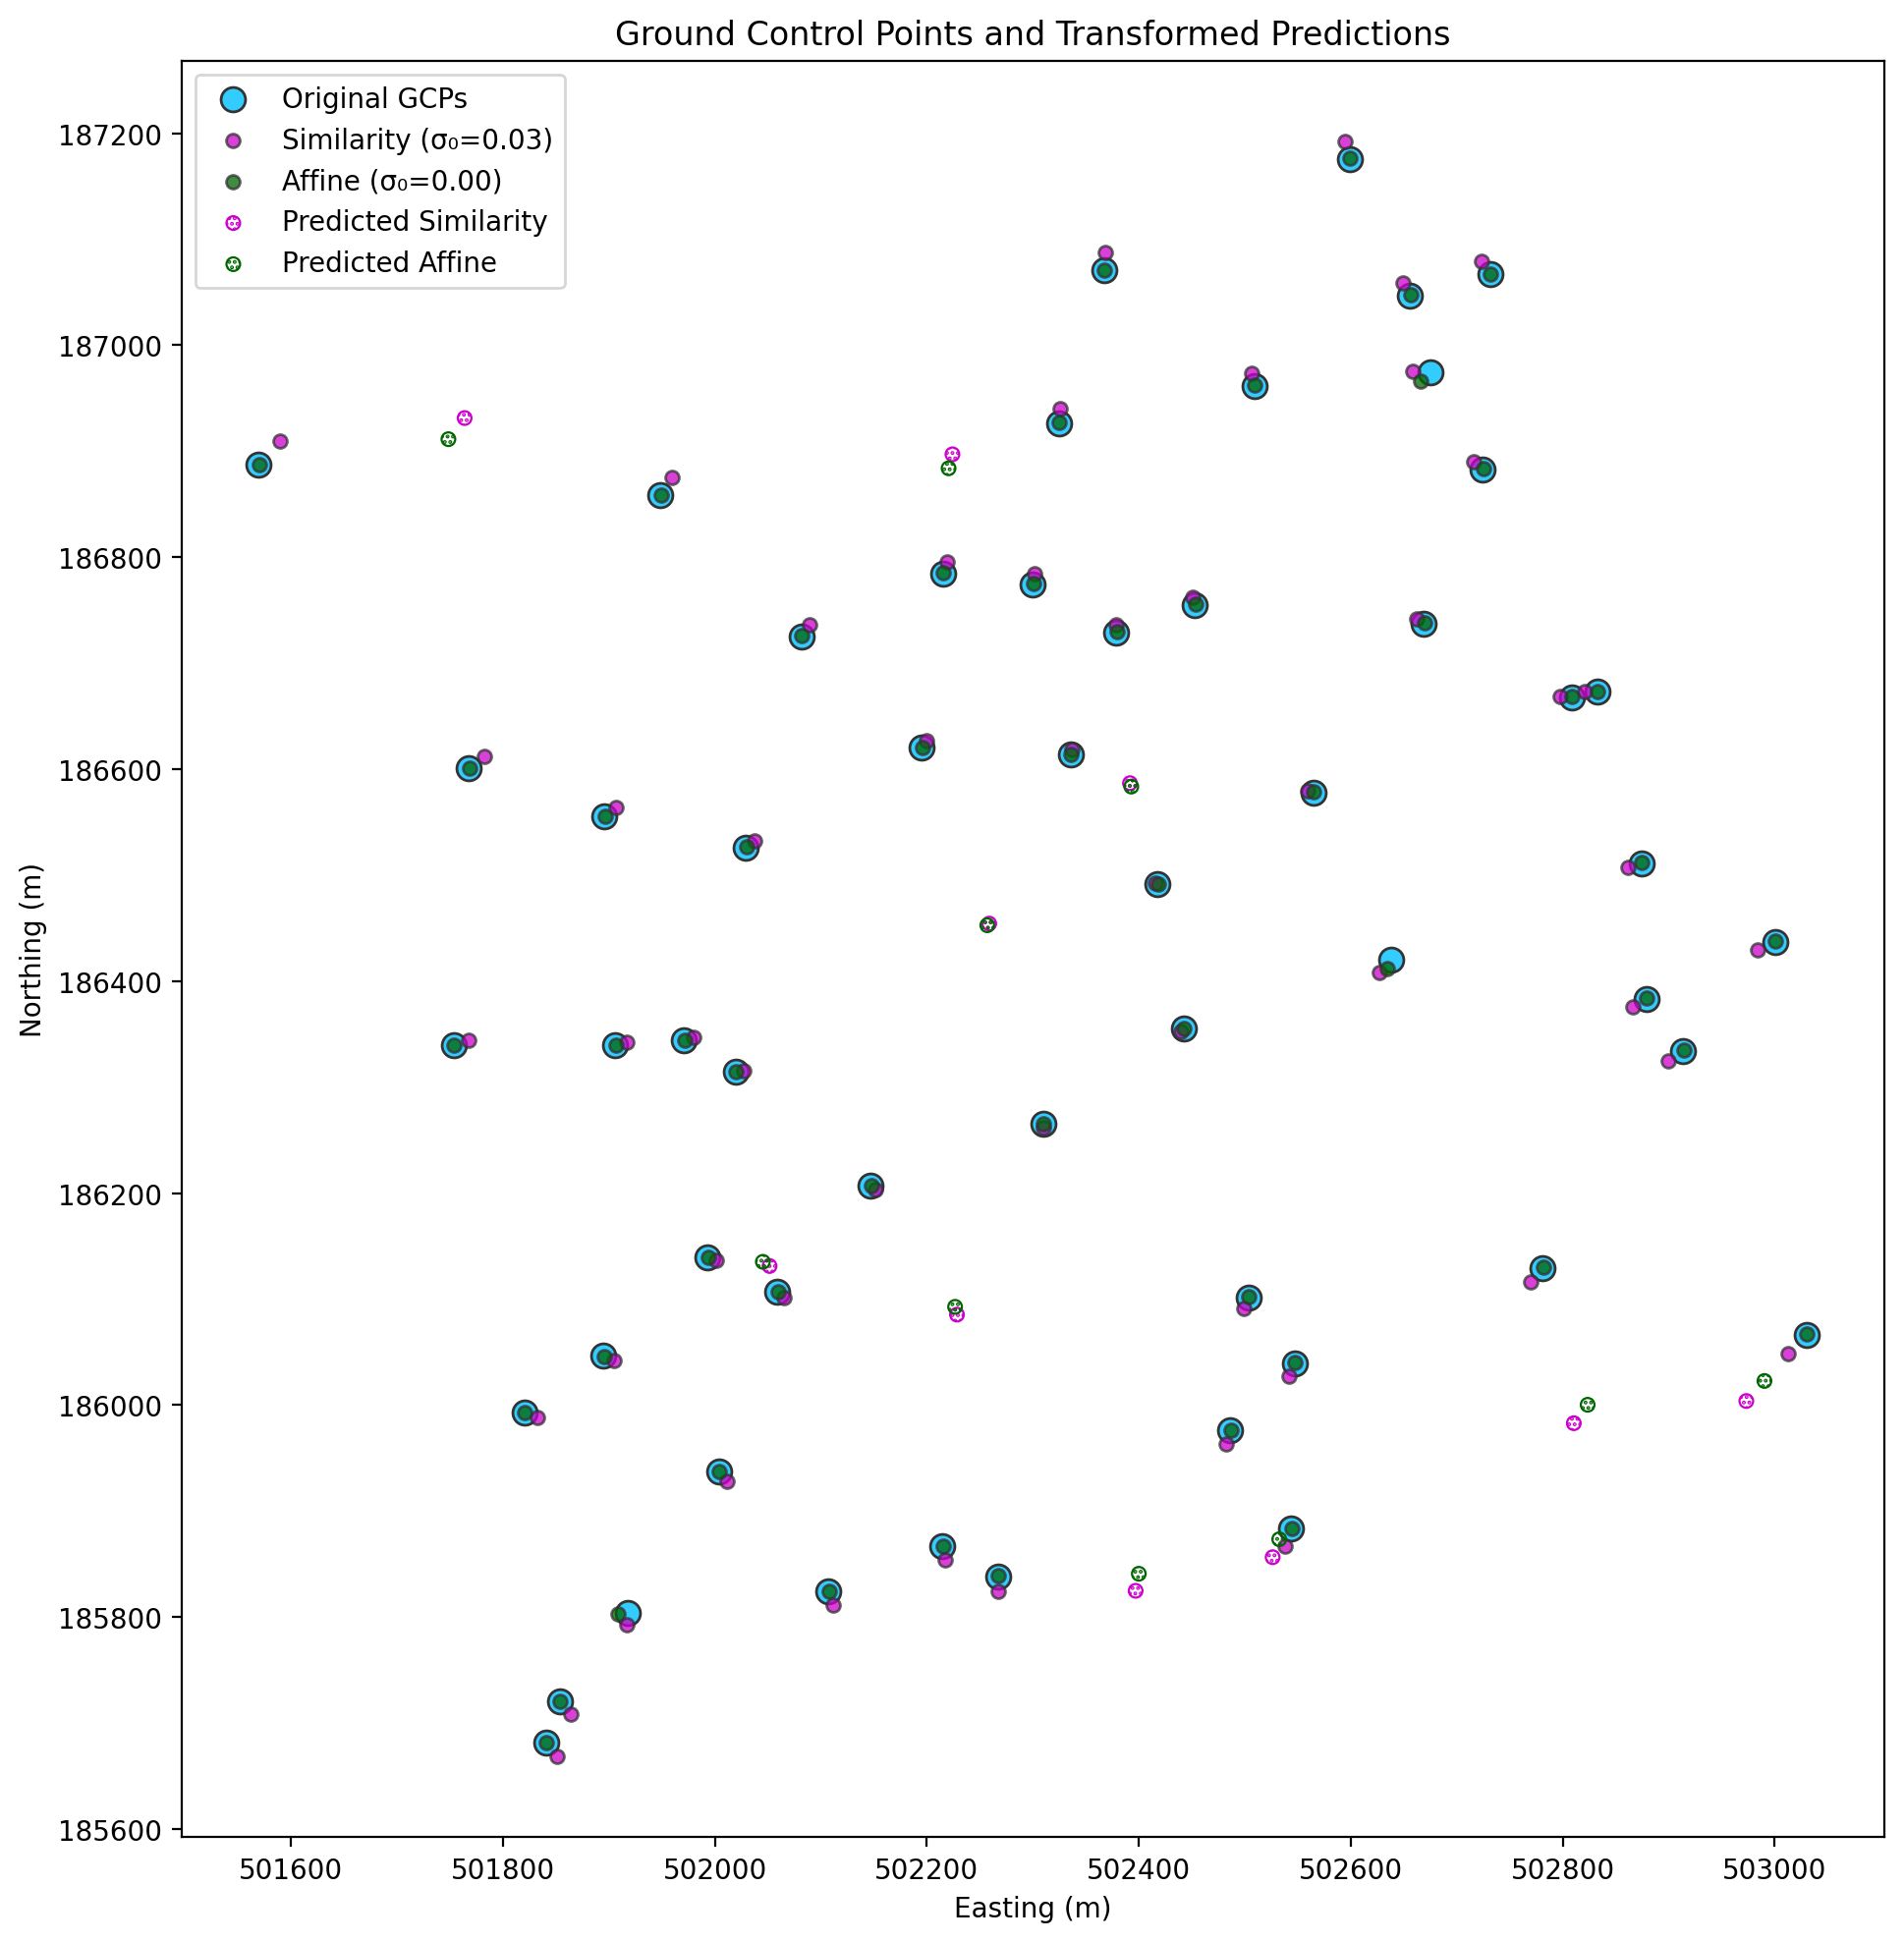

In [ ]:
# Predicted ground coordinates from each model
pred_sim = similarity_results.predict()
pred_aff = affine_results.predict()

# Split into E and N
pred_E_sim, pred_N_sim = pred_sim[:half], pred_sim[half:]
pred_E_aff, pred_N_aff = pred_aff[:half], pred_aff[half:]

# Plot
fig, ax = plt.subplots(figsize=(10, 10))

orig = ax.scatter(ground_control_points['E'], ground_control_points['N'],
                  c='#33CCFF', edgecolor='#333333', s=80, alpha=1.0, label='Original GCPs')
sim = ax.scatter(pred_E_sim, pred_N_sim, 
                 c='#CC00CC', edgecolor='#333333', s=25, alpha=0.75,
                 label=f'Similarity (σ₀={sigma0_sim:.2f})')
aff = ax.scatter(pred_E_aff, pred_N_aff,
                 c='#006600', edgecolor='#333333', s=25, alpha=0.75,
                 label=f'Affine (σ₀={sigma0_aff:.2f})')

pred_sim = plt.scatter(
    predicted_similarity[:len(rpoints)],
    predicted_similarity[len(rpoints):],
    lw=.8,
    s=25,
    color='none',
    edgecolor='#CC00CC',
    hatch='......',
    alpha=1.,
    label="Predicted Similarity",
)

pred_aff = plt.scatter(
    predicted_affine[:len(rpoints)],
    predicted_affine[len(rpoints):],
    lw=.8,
    s=25,
    color='none',
    edgecolor='#006600',
    hatch='......',
    alpha=1.,
    label="Predicted Affine",
)

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
ax.set_title('Ground Control Points and Transformed Predictions')
ax.legend(loc='upper left')
ax.set_aspect('equal')
plt.tight_layout()
plt.savefig('../WLS.png', format="png", bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Transform New Points

Use the fitted parameters to transform arbitrary image coordinates to ground coordinates.

In [ ]:
def transform_similarity(x, y, params):
    """Apply similarity transform: image → ground"""
    a, b = params['a'], params['b']
    dE, dN = params['Delta_E'], params['Delta_N']
    E = a * x - b * y + dE
    N = b * x + a * y + dN
    return E, N

def transform_affine(x, y, params):
    """Apply affine transform: image → ground"""
    E = params['a0'] + params['a1x'] * x + params['a2y'] * y
    N = params['b0'] + params['b1x'] * x + params['b2y'] * y
    return E, N

# Test with a new point
test_x, test_y = 0.05, 0.05
E_sim, N_sim = transform_similarity(test_x, test_y, sim_params)
E_aff, N_aff = transform_affine(test_x, test_y, aff_params)

print(f"Test point: x={test_x}, y={test_y}")
print(f"Similarity: E={E_sim:.2f}, N={N_sim:.2f}")
print(f"Affine:     E={E_aff:.2f}, N={N_aff:.2f}")

Test point: x=0.05, y=0.05
Similarity: E=502470.38, N=186742.85
Affine:     E=502473.25, N=186736.69


### Using a Transformation Matrix

We could also use a transformation matrix to transform given imaged `x` and `y` coordinates. The parameters returned by our `fit()` method allow us to accomplish this, once we've arranged our input points in the correct shape.

The transformation matrix for the affine transform is as follows:

\begin{align}
\begin{bmatrix}
    x'& \dots& x'_{n}\\\
    y'& \dots& y'_{n}\\\
    1& \dots& 1_{n}
\end{bmatrix}
=
\begin{bmatrix}
    a1x& a2y& a&\\\
    b1x& b2y& b&\\\
    0& 0& 1
\end{bmatrix}
\begin{bmatrix}
    x& \dots& x_{n}\\\
    y& \dots& y_{n}\\\
    1& \dots& 1_{n}
\end{bmatrix}
\end{align}

([Goshtasby, A.A., 2012. Image Registration: Principles, Tools and Methods. p348]((https://books.google.co.uk/books?id=VthiwQOT6t4C&pg=PA347&lpg=PA347&dq=affine+transform+a+a1x+a2y&source=bl&ots=8WOI4xglcn&sig=iQ3VpSD7xzJ6XIa7ZWhgFm-Izto&hl=en&sa=X&ei=oseOVKbsJofD7gaC6IDgDQ&ved=0CD4Q6AEwBg#v=onepage&q=affine%20transform%20a%20a1x%20a2y&f=false)))


To which we add the intercept we've calculated.

In [ ]:
def affine_oob(params, points):
  """
  Calculate out-of-band points using least-squares params
  inputs:
      params: statsmodels results object with fitted parameters
      points: List or array of (x, y) image coordinate tuples
  returns list of affine-transformed (E, N) ground coordinate tuples
  """
  p = params.params

  # Form affine transformation matrix (homogeneous coordinates)
  # [E]   [a1x  a2y  a0] [x]
  # [N] = [b1x  b2y  b0] [y]
  # [1]   [0    0    1 ] [1]
  tmatrix = np.array([
      [p['a1x'], p['a2y'], p['a0']],
      [p['b1x'], p['b2y'], p['b0']],
      [0,        0,        1      ]
  ])

  # Form point matrix: each column is [x, y, 1]^T
  points = np.array(points)
  homogeneous = np.vstack([points.T, np.ones(len(points))])

  # Transform: result columns are [E, N, 1]^T
  result = tmatrix @ homogeneous

  return list(zip(result[0], result[1]))

In [ ]:
# second result from statsmodels prediction
predicted_affine[1], predicted_affine[11] 

(502421.88483724056, 187062.85039907647)

In [ ]:
res = affine_oob(affine_results, rpoints)
# second manually-calculated point
res[1]

(np.float64(502421.88483724056), np.float64(187062.85039907647))

## Conclusion

Based on the sigma-nought ($\sigma_0$) values:
- **Similarity**: $\sigma_0$ = larger value → worse fit
- **Affine**: $\sigma_0$ = smaller value → better fit

The **affine transformation** provides a better fit to the data, as expected since it has more degrees of freedom (6 vs 4 parameters) and can model non-uniform scaling and shear that the similarity transform cannot.